In [15]:
# import libraries
import numpy as np
import pandas as pd
import re
import string
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
import io
import csv
from pandas import DataFrame
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# WebScraping Code

In [16]:
from selenium import webdriver, common
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
import pandas as pd
import sys

def edmundWebScraper(url, pages):
    """
    Scrape Data from a given forum on Edmund's
    :param url: url of page one of Edmund forum
           pages: number of pages of forum to scrape
    :return: returns a pandas dataframe of comments
    """
    # Initialize Driver
    driver = webdriver.Chrome('chromedriver.exe', options=chrome_options)
    driver.set_page_load_timeout(60)
    driver.get(url)

    # Create Empty Dataframe
    comments = pd.DataFrame()
    for i in range(1, pages+1):
        sys.stdout.write('\r')
        sys.stdout.write('Percent Complete:  ' + str(round((i / (pages + 1)) * 100, 2)) + '%' + ', Page: ' + str(i))
        sys.stdout.flush()
        url = f'{url}/p{i}'
        try:
            page_comments = scrapePageComments(driver, url)
            comments = comments.append(page_comments)
        except common.exceptions.TimeoutException:
            continue

        driver.find_element_by_class_name('Next').click()

    return comments


def scrapePageComments(driver, url):
    """
    Scrape Data from a given page of a forum on Edmund's
    :param driver: webdriver
    :return: returns a pandas dataframe of comments
    """
    # Create Empty containers for Values
    c_dates = []
    c_texts = []
    c_authors = []

    # Update Driver
    driver.get(url)
    # Retrieve Comments
    ul_comments = driver.find_elements_by_xpath('//*[@id="Content"]/div[4]/div[1]/ul')[0]
    comments = ul_comments.find_elements_by_tag_name('li')
    for comment in comments:
        try:
            comment_id = comment.get_attribute('id')[8:]
            # If Block Quote
            if comment.find_elements_by_xpath(f'//*[@id="Comment_{comment_id}"]/div/div[3]/div/div[1]/blockquote'):
                element = driver.find_element_by_tag_name('blockquote')
                driver.execute_script("""
                  var element = arguments[0];
                  element.parentNode.removeChild(element);
                  """, element)
                text = comment.find_element_by_xpath(f'//*[@id="Comment_{comment_id}"]/div/div[3]/div/div[1]').text
            # If not block quote
            else:
                text = comment.find_elements_by_xpath(f'//*[@id="Comment_{comment_id}"]/div/div[3]/div/div[1]')[0].text
            date = comment.find_element_by_xpath(f'//*[@id="Comment_{comment_id}"]/div/div[2]/div[2]/span/a/time').get_attribute('datetime')
            author = comment.find_element_by_xpath(f'//*[@id="Comment_{comment_id}"]/div/div[2]/div[1]/span[1]/a[2]').text
            c_dates.append(date)
            c_authors.append(author)
            c_texts.append(text)
        except IndexError:
            continue
        except common.exceptions.StaleElementReferenceException:
            continue
    return {'date': c_dates, 'author': c_authors, 'text': c_texts}

# Read in Data

In [17]:
# read in data and rename columns
df = pd.read_csv('scrapedData.csv')
df.rename(columns = {'Date': 'date'}, inplace = True)
df.drop(columns=['PageCommentNumber'], inplace = True)
df.head()

,date,author,text
0,2004-04-02T13:43:55+00:00,fintail,"This isn't totally new, but I saw my first Sci..."
1,2004-04-02T13:52:23+00:00,andre1969,I saw both a Colorado and a Malibu in DC. I kn...
2,2004-04-02T15:25:54+00:00,lemko,...but I saw a Mazda 3 last week.
3,2004-04-02T15:28:12+00:00,andre1969,"sometimes though, at a quick glance it takes m..."
4,2004-04-02T16:07:00+00:00,PF_Flyer,"Yea, we can have some retroactive sightings to..."


In [18]:
# convert comments column to strings
df['text'] = df['text'].apply(str)
# create a list of the comments
comments = df['text'].tolist()

# Get top 10 Brands

In [19]:
def replaceModelWBrand(tokens, wordBrandCSV):
    """
    Replace Model Occurance with Brand
    :param tokens: list of all important words in comments
    :param wordBrandCSV: CSV of word-brand association
    :return: a list of allBrands mentioned in the comments
    """
    brandWordAssociation = pd.read_csv(wordBrandCSV)
    brandWords = list(brandWordAssociation['Model'])
    
    #list of models 
    models = brandWordAssociation['Model']
    #list of brands
    brands = brandWordAssociation['Brand']
    
    # Dictionary mapping model to brand
    brandWordAssociation = {models[i]: brands[i] for i in range(len(models))} 
    
    for i in range(len(tokens)):
        word = tokens[i].lower()
        if word in brandWords:
            tokens[i] = brandWordAssociation[word]
    return tokens

In [20]:
def get_word_frequency(wordlist):
 
    # replace slash with space
    wordlist = wordlist.replace("/", " ")
    wordlist = wordlist.replace("_", " ")
    wordlist = wordlist.replace("'", " ")
    wordlist = wordlist.replace("-", " ")
        
    # create list of words for the comment
    tokens = nltk.tokenize.word_tokenize(wordlist)
 
    # Get list of English stop words
    take_out = stopwords.words('english')
    take_out = [word.upper() for word in take_out]
 
    # Convert word to uppercase
    tokens = [word.upper() for word in tokens]
 
    # Filter out stop words and punctuation from tokens list
    tokens = [word for word in tokens if word not in take_out]
    tokens = [word for word in tokens if word not in string.punctuation]
    tokens = [word for word in tokens if word[0] not in string.punctuation]
    
    # Convert word to lowercase
    tokens = [word.lower() for word in tokens]
    
    # Replace model w Brand
    tokens = replaceModelWBrand(tokens, 'carmodelsandbrands.csv')
 
    # Get word frequency distribution
    word_frequencies = nltk.FreqDist(tokens)
 
    # Sort word frequency distribution by number of times each word occurs
    sorted_counts = sorted(word_frequencies.items() , key = lambda x: x[1] ,
                           reverse = True)
 
    return sorted_counts

In [21]:
preresults = [x for x in comments if x != '']
results = [get_word_frequency(x) for x in preresults]

# get list of unique words in posts
allwords = []
for comment in results:
    for word in comment:
        # Append Word form (Word, Occurance) tuple
        allwords.append(word[0])
        
# get word frequency across all comments (counting each word only once per post)
overall_text = ' '.join(allwords)
top_words = get_word_frequency(overall_text)
overall_freq = DataFrame(top_words,columns=['word','count'])

In [22]:
# Filter to just top 10 Brands
brandVModel = pd.read_csv('carmodelsandbrands.csv')
brands = list(brandVModel['Brand'].unique())
brand_freq = overall_freq[overall_freq['word'].isin(brands)]
topbrands = brand_freq[0:10]
topBrandNames = list(topbrands['word'])
topbrands

,word,count
9,toyota,1456
17,honda,1218
31,bmw,978
34,ford,930
35,chevrolet,913
54,nissan,738
55,hyundai,732
63,audi,617
83,volkswagen,538
95,mazda,517


# Calculate Lift of Top 10 Brands

In [23]:
def count_coocurances(coocurance_words, multipleTokens):
    """
    Count coocurances between a list of words within mulitple tokens
    :param coocurance_words: list of words to analyze coocurance
    :param multipleTokens: list of all comments which have been converted to tokens
    :return: a coocurance dataframe (essentially matrix) where to indices and columns are the coocurance words
    """
    # Create Dataframe filled w 0s
    d = pd.DataFrame(0, index=coocurance_words, columns=coocurance_words)
    
    # Loop through all tokens (comments)
    for tokens in multipleTokens:
        # Create Temp Dataframe
        dTemp = pd.DataFrame(0, index=coocurance_words, columns=coocurance_words)
        # Loop through words
        for word1 in coocurance_words:
            # If word appears in token (comment), increment diagonal
            if word1 in tokens:
                dTemp.loc[ word1 , word1 ] += 1
                for word2 in coocurance_words:
                    # If words coocur in tokens (comment) increment value
                    if word2 in tokens and word2 != word1:
                        dTemp.loc[ word1, word2 ] += 1
                        
        # Add dataframes together
        d = d.add(dTemp, fill_value=0)
    
    return d

In [24]:
def get_tokens(comment):
    """
    Convert comment to tokens
    :param comment: list of words contained in comment
    :return: tokens representing words in comment
    """
    # replace slash with space
    comment = comment.replace("/", " ")
    comment = comment.replace("_", " ")
    comment = comment.replace("'", " ")
    comment = comment.replace("-", " ")
        
    # create list of words for the comment
    tokens = nltk.tokenize.word_tokenize(comment)
 
    # Get list of English stop words
    take_out = stopwords.words('english')
    take_out = [word.upper() for word in take_out]
 
    # Convert word to uppercase
    tokens = [word.upper() for word in tokens]
 
    # Filter out stop words and punctuation from tokens list
    tokens = [word for word in tokens if word not in take_out]
    tokens = [word for word in tokens if word not in string.punctuation]
    tokens = [word for word in tokens if word[0] not in string.punctuation]
    
    # Convert word to lowercase
    tokens = [word.lower() for word in tokens]
    
    # Replace model w Brand
    tokens = replaceModelWBrand(tokens, 'carmodelsandbrands.csv')
    
    return tokens

In [25]:
preresults = [x for x in comments if x != '']
results = [get_tokens(x) for x in preresults]

In [26]:
coocuranceDF_top10Brands = count_coocurances(coocurance_words=topBrandNames, multipleTokens=results)
coocuranceDF_top10Brands

,toyota,honda,bmw,ford,chevrolet,nissan,hyundai,audi,volkswagen,mazda
toyota,1456,276,84,134,114,112,106,52,88,88
honda,276,1218,104,97,102,95,102,63,68,73
bmw,84,104,978,70,44,57,67,141,51,45
ford,134,97,70,930,115,81,66,46,62,66
chevrolet,114,102,44,115,913,64,45,35,36,39
nissan,112,95,57,81,64,738,62,26,38,48
hyundai,106,102,67,66,45,62,732,46,37,28
audi,52,63,141,46,35,26,46,617,65,23
volkswagen,88,68,51,62,36,38,37,65,538,35
mazda,88,73,45,66,39,48,28,23,35,517


In [27]:
def calculateLift(word1, word2, N, coocuranceDF):
    numAB = coocuranceDF.loc[ word1, word2 ]
    numA = coocuranceDF.loc [ word1, word1 ]
    numB = coocuranceDF.loc [ word2, word2 ]
    
    liftAB = (N * numAB) / (numA * numB)
    
    return liftAB

In [28]:
N = len(comments)
liftDF_top10Brands = pd.DataFrame(0, index=topBrandNames, columns=topBrandNames)
for brand1 in topBrandNames:
    for brand2 in topBrandNames:
        if brand1 == brand2:
            # Should be Zero (Set to .000000001 to allow reciprocal)
            liftDF_top10Brands.loc[ brand1, brand2 ] = 0.0000000000001
        else:
            liftDF_top10Brands.loc[ brand1, brand2 ] = calculateLift(word1=brand1, word2=brand2, N=N, coocuranceDF=coocuranceDF_top10Brands)
liftDF_top10Brands

,toyota,honda,bmw,ford,chevrolet,nissan,hyundai,audi,volkswagen,mazda
toyota,1.000000e-13,2.465220e+00,9.344030e-01,1.567529e+00,1.358401e+00,1.651032e+00,1.575392e+00,9.168789e-01,1.779484e+00,1.851765e+00
honda,2.465220e+00,1.000000e-13,1.382937e+00,1.356428e+00,1.452905e+00,1.674076e+00,1.812162e+00,1.327894e+00,1.643745e+00,1.836286e+00
bmw,9.344030e-01,1.382937e+00,1.000000e-13,1.219078e+00,7.805455e-01,1.250935e+00,1.482450e+00,3.701266e+00,1.535339e+00,1.409738e+00
ford,1.567529e+00,1.356428e+00,1.219078e+00,1.000000e-13,2.145356e+00,1.869394e+00,1.535695e+00,1.269828e+00,1.962825e+00,2.174331e+00
chevrolet,1.358401e+00,1.452905e+00,7.805455e-01,2.145356e+00,1.000000e-13,1.504555e+00,1.066561e+00,9.841636e-01,1.160926e+00,1.308755e+00
nissan,1.651032e+00,1.674076e+00,1.250935e+00,1.869394e+00,1.504555e+00,1.000000e-13,1.817939e+00,9.044551e-01,1.516003e+00,1.992735e+00
hyundai,1.575392e+00,1.812162e+00,1.482450e+00,1.535695e+00,1.066561e+00,1.817939e+00,1.000000e-13,1.613306e+00,1.488208e+00,1.171957e+00
audi,9.168789e-01,1.327894e+00,3.701266e+00,1.269828e+00,9.841636e-01,9.044551e-01,1.613306e+00,1.000000e-13,3.101709e+00,1.142108e+00
volkswagen,1.779484e+00,1.643745e+00,1.535339e+00,1.962825e+00,1.160926e+00,1.516003e+00,1.488208e+00,3.101709e+00,1.000000e-13,1.993198e+00
mazda,1.851765e+00,1.836286e+00,1.409738e+00,2.174331e+00,1.308755e+00,1.992735e+00,1.171957e+00,1.142108e+00,1.993198e+00,1.000000e-13


# MDS Plot (Lift)

Text(0.5, 1.0, 'MDS Plot')

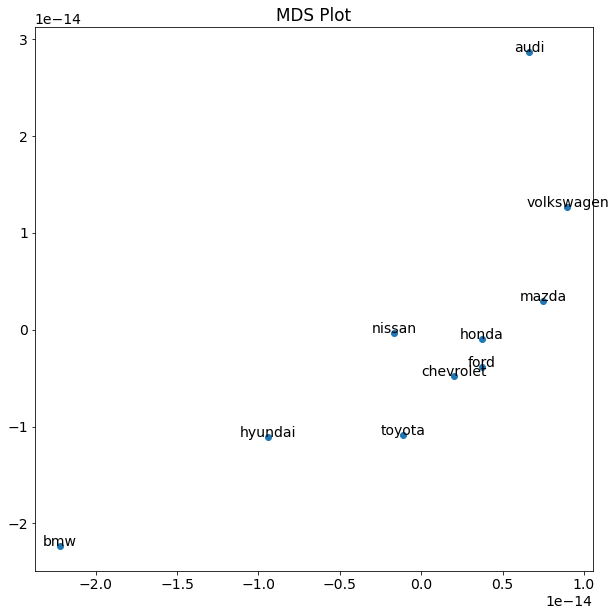

In [29]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler


# Take reciprocal of every element
liftDF_reciprocal = np.reciprocal(liftDF_top10Brands)

# have to scale the data to feed into the MDS function
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(liftDF_reciprocal)

#fitting the MDS plot
mds = MDS(2,random_state=0, dissimilarity='precomputed')
X_2d = mds.fit_transform(df_scaled)

# formatting the output table
brands = liftDF_top10Brands.index.values
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc('font', size=14)

#grabbing X,Y values
x = [row[0] for row in X_2d]
y = [row[1] for row in X_2d]

#plotting
plt.scatter(x,y)

#naming the points by brand on the MDS plot. 
i=0
for x,y in zip(x,y):
    plt.annotate(brands[i], (x,y), ha='center')
    i+=1

# Add title
plt.title('MDS Plot')

# Attributes of Top 10 Brands

In [30]:
attributes = ['style', 'price', 'interior', 'engine', 'wheels']
topBrandNamesCopy = topBrandNames.copy()
topBrandNamesCopy.extend(attributes)
attributesANDbrands = topBrandNamesCopy.copy()

coocuranceDF_top10BrandsAttributes = count_coocurances(coocurance_words=attributesANDbrands, multipleTokens=results)

In [31]:
#coocuranceDF = count_coocurances(coocurance_words=attributesANDbrands, multipleTokens=results)
coocuranceDF_top10BrandsAttributes[len(topBrandNames):][topBrandNames]

,toyota,honda,bmw,ford,chevrolet,nissan,hyundai,audi,volkswagen,mazda
style,60,54,39,35,35,28,31,38,26,20
price,63,65,43,35,38,33,51,33,27,17
interior,69,74,41,39,42,38,35,35,29,26
engine,41,42,24,37,27,22,28,17,25,24
wheels,43,54,34,39,33,13,24,19,27,11


In [32]:
N = len(comments)
liftDF_top10BrandsAttributes = pd.DataFrame(0, index=attributes, columns=topBrandNames)
for attribute in attributes:
    for brand in topBrandNames:
        liftDF_top10BrandsAttributes.loc[ attribute, brand ] = calculateLift(word1=attribute, word2=brand, N=N, coocuranceDF=coocuranceDF_top10BrandsAttributes)
liftDF_top10BrandsAttributes

,toyota,honda,bmw,ford,chevrolet,nissan,hyundai,audi,volkswagen,mazda
style,1.431463,1.540057,1.385211,1.307301,1.331642,1.317929,1.471096,2.139384,1.678732,1.343785
price,1.627992,2.007886,1.654256,1.415983,1.565979,1.682405,2.621393,2.012342,1.888229,1.237176
interior,1.770423,2.269728,1.566153,1.566646,1.718572,1.923608,1.786267,2.119201,2.013748,1.878764
engine,1.281736,1.569560,1.116988,1.810901,1.346074,1.356883,1.741097,1.254122,2.115113,2.112986
wheels,1.092996,1.640808,1.286623,1.552005,1.337687,0.651926,1.213421,1.139672,1.857346,0.787433


In [33]:
aspirationalPhrases = [
    "wish to", 'love to', 'dream of', 'want to', 'like to', 'really want', 'saving up', 'hope to'
]

aspirationalPhrasesMapping = {}

for i, aspirationalPhrase in enumerate(aspirationalPhrases):
    aspirationalPhrasesMapping[aspirationalPhrase] = "aspirationalphrase"

def findAspirationalPhrases(comment):
    for aspirationalPhrase in aspirationalPhrasesMapping.keys():
        comment = comment.replace(aspirationalPhrase, aspirationalPhrasesMapping[aspirationalPhrase])
    return comment

In [34]:
# read in data and rename columns
df = pd.read_csv('scrapedData.csv')
df.rename(columns = {'Date': 'date'}, inplace = True)
df.drop(columns=['PageCommentNumber'], inplace = True)

# convert comments column to strings
df['text'] = df['text'].apply(str)

# Replace aspirational phrases with filler
df['text'] = df['text'].map(findAspirationalPhrases)

df.head()

,date,author,text
0,2004-04-02T13:43:55+00:00,fintail,"This isn't totally new, but I saw my first Sci..."
1,2004-04-02T13:52:23+00:00,andre1969,I saw both a Colorado and a Malibu in DC. I kn...
2,2004-04-02T15:25:54+00:00,lemko,...but I saw a Mazda 3 last week.
3,2004-04-02T15:28:12+00:00,andre1969,"sometimes though, at a quick glance it takes m..."
4,2004-04-02T16:07:00+00:00,PF_Flyer,"Yea, we can have some retroactive sightings to..."


In [35]:
# create a list of the comments
comments = df['text'].tolist()

In [36]:
preresults = [x for x in comments if x != '']
results = [get_tokens(x) for x in preresults]

In [37]:
topBrandNamesCopy = topBrandNames.copy()
topBrandNamesCopy.extend(['aspirationalphrase'])
aspirationsANDbrands = topBrandNamesCopy.copy()

coocuranceDF_aspirations = count_coocurances(coocurance_words=aspirationsANDbrands, multipleTokens=results)
coocuranceDF_aspirations

,toyota,honda,bmw,ford,chevrolet,nissan,hyundai,audi,volkswagen,mazda,aspirationalphrase
toyota,1456,276,84,134,114,112,106,52,88,88,39
honda,276,1218,104,97,102,95,102,63,68,73,38
bmw,84,104,978,70,44,57,67,141,51,45,23
ford,134,97,70,930,115,81,66,46,62,66,22
chevrolet,114,102,44,115,913,64,45,35,36,39,27
nissan,112,95,57,81,64,738,62,26,38,48,18
hyundai,106,102,67,66,45,62,732,46,37,28,30
audi,52,63,141,46,35,26,46,617,65,23,21
volkswagen,88,68,51,62,36,38,37,65,538,35,16
mazda,88,73,45,66,39,48,28,23,35,517,16


In [39]:
coocuranceDF_aspirations[len(topBrandNames):][topBrandNames]

,toyota,honda,bmw,ford,chevrolet,nissan,hyundai,audi,volkswagen,mazda
aspirationalphrase,39,38,23,22,27,18,30,21,16,16


In [40]:
N = len(comments)
liftDF_aspirations = pd.DataFrame(0, index=list(aspirationalPhrasesMapping.keys()), columns=topBrandNames)
for aspirationalPhrase in list(aspirationalPhrasesMapping.keys()):
    for brand in topBrandNames:
        liftDF_aspirations.loc[ aspirationalPhrase, brand ] = calculateLift(word1=aspirationalPhrasesMapping[aspirationalPhrase], 
                                                                word2=brand, N=N, coocuranceDF=coocuranceDF_aspirations
                                                               )
liftDF_aspirations

,toyota,honda,bmw,ford,chevrolet,nissan,hyundai,audi,volkswagen,mazda
wish to,1.289622,1.502089,1.132265,1.138935,1.423811,1.17429,1.973192,1.638677,1.431848,1.490008
love to,1.289622,1.502089,1.132265,1.138935,1.423811,1.17429,1.973192,1.638677,1.431848,1.490008
dream of,1.289622,1.502089,1.132265,1.138935,1.423811,1.17429,1.973192,1.638677,1.431848,1.490008
want to,1.289622,1.502089,1.132265,1.138935,1.423811,1.17429,1.973192,1.638677,1.431848,1.490008
like to,1.289622,1.502089,1.132265,1.138935,1.423811,1.17429,1.973192,1.638677,1.431848,1.490008
really want,1.289622,1.502089,1.132265,1.138935,1.423811,1.17429,1.973192,1.638677,1.431848,1.490008
saving up,1.289622,1.502089,1.132265,1.138935,1.423811,1.17429,1.973192,1.638677,1.431848,1.490008
hope to,1.289622,1.502089,1.132265,1.138935,1.423811,1.17429,1.973192,1.638677,1.431848,1.490008
